In [1]:
%cd ../..

c:\Users\aldion\Desktop\Development\virtusize-algo


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from src.steps.load_data import load_experiment_data
from src.steps.predict import predict_serving_data
from src.steps.train import train
from src.utils.error_analyzer import ErrorAnalyzer
from src.utils.error_calculator import calculate_split_errors, get_split_error_data
from src.utils.feature_engineer import BMIProxyEngineer, FeatureDropper, FeatureScaler
from src.utils.ground_truths import get_ground_truth_values
from src.utils.metrics import MetricsManager
from src.utils.models import FitParams, ModelNames, VirtusizeModels
from src.utils.neural_net import build_model
from src.utils.predictions import get_train_val_test_predictions





In [3]:
RANDOM_SEED= 100
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [4]:
scaler = FeatureScaler(StandardScaler(), cols_to_scale=["weight", "bmi_proxy", "age"])
dropper = FeatureDropper(["height"])
bmi_engineer = BMIProxyEngineer()
feature_engineers = [bmi_engineer, scaler, dropper] # Ensure bmi_engineer is added first so that the bmi_proxy columns is added at the time scaling is being done


In [5]:
experiment_data = load_experiment_data(feature_engineers=feature_engineers)
train_val_test = experiment_data.train_val_test

In [6]:
train_val_test.train.bust.features.head()

,gender,age,weight,bmi_proxy
664,1,-1.005660,-0.236478,0.492185
1013,0,0.180270,-1.256858,1.588829
153,0,0.319791,-0.252298,0.199040
392,0,1.156918,-0.109919,-0.101876
3598,1,1.575482,0.538694,-0.806016


In [7]:
train_val_test.train.bust.targets.head()

664     830.0
1013    765.0
153     823.0
392     986.0
3598    976.0
Name: bust_circumference, dtype: float64

In [8]:
universal_fit_params = {"batch_size": 64, "epochs":500}
fit_params = FitParams()
fit_params.update_with_validation_data(train_val_test)
fit_params.update_all(universal_fit_params)

In [9]:
bust_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}
hip_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}
waist_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}

In [10]:
fit_params.bust.update(bust_callbacks)
fit_params.hip.update(hip_callbacks)
fit_params.waist.update(waist_callbacks)

In [11]:
num_features = 4
bust_model = build_model(num_features)
hip_model = build_model(num_features)
waist_model = build_model(num_features)

models = VirtusizeModels(bust_model, hip_model, waist_model, names=ModelNames(bust="nn_bust", hip="nn_hip", waist="nn_waist"))

In [12]:
train_history = train(models, train_val_test.train, fit_params)

Training bust circumference  prediction model...
Epoch 1/500
57/57 [==============================] - 1s 7ms/step - loss: 732877.1875 - val_loss: 367812.1875
Epoch 2/500
57/57 [==============================] - 0s 4ms/step - loss: 98319.6719 - val_loss: 40482.9375
Epoch 3/500
57/57 [==============================] - 0s 4ms/step - loss: 35106.2148 - val_loss: 19235.5469
Epoch 4/500
57/57 [==============================] - 0s 4ms/step - loss: 19310.3516 - val_loss: 8191.1138
Epoch 5/500
57/57 [==============================] - 0s 4ms/step - loss: 12104.9541 - val_loss: 3992.6248
Epoch 6/500
57/57 [==============================] - 0s 4ms/step - loss: 9437.9062 - val_loss: 2806.0725
Epoch 7/500
57/57 [==============================] - 0s 4ms/step - loss: 8324.4854 - val_loss: 2259.9668
Epoch 8/500
57/57 [==============================] - 0s 5ms/step - loss: 8136.4355 - val_loss: 1904.8600
Epoch 9/500
57/57 [==============================] - 0s 4ms/step - loss: 7875.5967 - val_loss: 1744.1

### Universal Metrics Analysis

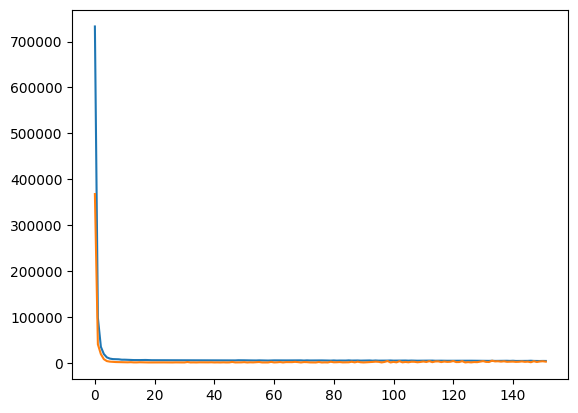

In [13]:
plt.plot(train_history.bust.history["loss"])
plt.plot(train_history.bust.history["val_loss"])

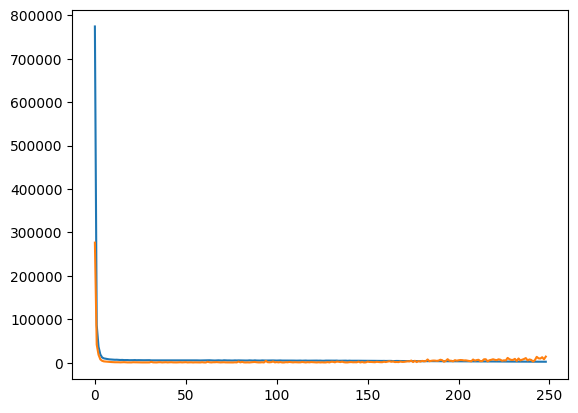

In [14]:
plt.plot(train_history.hip.history["loss"])
plt.plot(train_history.hip.history["val_loss"])

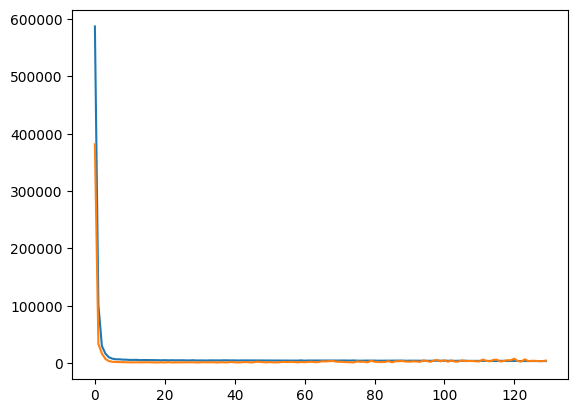

In [15]:
plt.plot(train_history.waist.history["loss"])
plt.plot(train_history.waist.history["val_loss"])

- Comparing the model's history on both the train and validation sets suggests that all models are highly likely to generalize the performances obtained on the training set to unseen test data with similar feature distribution patterns.

In [16]:
predictions = get_train_val_test_predictions(models, train_val_test)

25/25 [==============================] - 0s 1ms/step


In [17]:
ground_truths = get_ground_truth_values(train_val_test)

In [18]:
metrics_manager = MetricsManager()
metrics = metrics_manager.update_metrics(ground_truths, predictions)

In [19]:
metrics

,train_mae,val_mae,test_mae,train_mse,val_mse,test_mse,train_r2,val_r2,test_r2
nn_bust,23.428158,23.631121,24.203594,912.089512,959.830812,932.997835,0.876396,0.862544,0.870549
nn_hip,17.683506,18.290051,17.861958,544.249824,566.784406,526.213290,0.861409,0.847067,0.858710
nn_waist,25.090523,25.589921,23.744185,1097.568093,1155.151055,928.851018,0.893739,0.887920,0.906196


In [20]:
metrics_manager.show_validation_metrics()

,val_mae,val_mse,val_r2
nn_bust,23.631121,959.830812,0.862544
nn_hip,18.290051,566.784406,0.847067
nn_waist,25.589921,1155.151055,0.887920


- The table above compares the performance of the classifiers using the metrics; mean absolute error (mae), mean squared error (mse) and r squared score. Interestingly, the neural network trained without using height as a featured performed slightly better than the previous iteration that used height as a feature. This is not totally surprising as EDA demonstrated that height was not highly correlated with the targets and the feature feature interactions that were provided are likely captured in the bmi_proxy feature.
Comparing the performance of the classifiers on the train and validation sets suggests that this performance can be generalized to unseen data.

### Error Analysis

In [21]:
split_errors = calculate_split_errors(ground_truths.val, predictions.val)

In [22]:
error_data = get_split_error_data(ground_truths.val, predictions.val, experiment_data.original_preprocessed)

In [23]:
error_data

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
9,1,17.0,1654.0,61.3,845.0,738.0,910.0,12.187195,4.496521,7.452332,12.187195,4.496521,7.452332
11,0,58.0,1539.0,54.6,891.0,800.0,875.0,8.572449,33.400879,-2.287659,8.572449,33.400879,2.287659
22,0,33.0,1605.0,58.0,872.0,756.0,945.0,7.832336,-4.863953,-2.188232,7.832336,4.863953,2.188232
24,1,26.0,1786.0,72.8,971.0,813.0,940.0,-55.918762,22.411377,-12.604980,55.918762,22.411377,12.604980
32,1,24.0,1715.0,70.6,906.0,789.0,977.0,8.598572,-20.626343,18.547119,8.598572,20.626343,18.547119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,0,22.0,1535.0,42.5,744.0,626.0,794.0,18.663513,56.141846,4.441772,18.663513,56.141846,4.441772
5130,0,44.0,1628.0,59.3,915.0,770.0,926.0,-21.030212,13.383423,5.359314,21.030212,13.383423,5.359314
5132,1,32.0,1756.0,65.4,896.0,820.0,930.0,-18.337219,-6.755859,-58.700867,18.337219,6.755859,58.700867
5134,1,27.0,1760.0,75.0,930.0,845.0,983.0,6.359192,-8.452148,-17.157410,6.359192,8.452148,17.157410


In [24]:
error_analyzer = ErrorAnalyzer(error_data, column_num_categories_map={"age": 10, "weight": 10, "height": 10})

In [25]:
error_analyzer.get_category_means("gender")

,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,
0,33.796392,1581.417526,56.604897,871.868557,755.912371,928.855670,4.848608,1.969551,-0.523543,25.191630,20.219421,27.564278
1,31.540682,1719.829396,71.408399,923.440945,822.645669,955.446194,0.917730,-0.525266,0.679890,22.041942,16.325233,23.579290


In [26]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

- As we have seen with all models so far, the mean absolute errors for each target is higher for females, with the biggest disparity coming in the prediction of waist circumference.

In [27]:
error_analyzer.get_category_st_devs("gender")

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,,
0,0.000000,15.720736,57.415612,8.383898,77.880663,91.530416,53.723949,32.899566,26.198450,37.087424,21.708804,16.775367,24.818576
1,0.000000,14.449534,60.511423,12.170386,81.087263,100.117794,64.685635,28.464811,20.994924,30.496487,18.034425,13.211718,19.352391


- The standard deviations confirms that the models performed better when making predictions for males.

In [28]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

In [29]:
male_error_data = error_data[error_data["gender"] == 1]
female_error_data = error_data[error_data["gender"] == 0]

#### The charts below show the distributions of the absolute errors for both genders

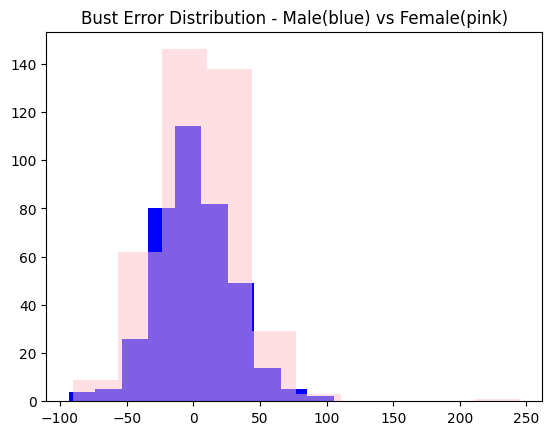

In [30]:
plt.hist(male_error_data["bust_errors"], bins=10, color="blue")
plt.hist(female_error_data["bust_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Bust Error Distribution - Male(blue) vs Female(pink)")
plt.show()


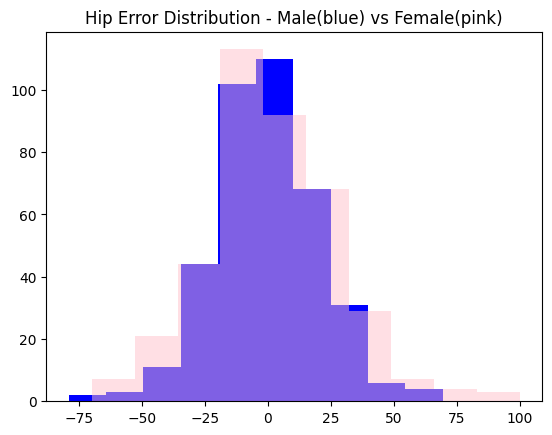

In [31]:
plt.hist(male_error_data["hip_errors"], bins=10, color="blue")
plt.hist(female_error_data["hip_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Hip Error Distribution - Male(blue) vs Female(pink)")
plt.show()

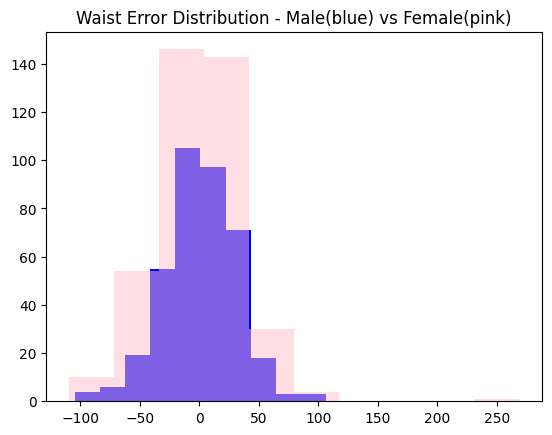

In [32]:
plt.hist(male_error_data["waist_errors"], bins=10, color="blue")
plt.hist(female_error_data["waist_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Waist Error Distribution - Male(blue) vs Female(pink)")
plt.show()

- The graphs indicate a relatively similar distribution of errors, but do confirm higher error rates when predicting female data.

### Further Error Analysis

In [33]:
error_analyzer.get_category_counts("age")

age
0    259
1     80
2     86
3     82
4     57
5     40
6     47
7     56
8     36
9     26
dtype: int64

In [34]:
error_analyzer.get_category_bin("age", 0)
# Most of the examples have individuals aged 15 to 20

(14.946, 20.4)

In [35]:
error_analyzer.get_category_means("age")

,gender,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
age,,,,,,,,,,,,
0,0.513514,1662.366795,61.010425,857.243243,735.849421,934.563707,5.844449,-1.693004,2.689750,23.208613,16.904463,22.557423
1,0.537500,1676.100000,65.787500,891.850000,776.862500,953.250000,4.893527,0.566985,1.352886,21.902403,19.315485,24.533335
2,0.523256,1677.267442,67.083721,909.267442,795.174419,960.802326,-1.066880,-3.025157,-1.878603,23.929946,19.735442,27.794172
3,0.524390,1670.195122,67.046341,917.768293,812.073171,952.475610,-3.162377,3.302439,-8.270273,21.800513,13.945940,25.643951
4,0.614035,1664.631579,66.975439,916.105263,812.807018,949.315789,1.850270,-1.213027,0.214679,24.678361,14.825149,24.422841
5,0.400000,1617.050000,61.337500,896.100000,791.125000,923.800000,5.069025,4.938261,4.080360,22.844785,23.150578,31.774858
6,0.425532,1616.170213,66.459574,940.744681,856.914894,950.234043,4.974554,3.582223,-4.983344,23.020413,22.542849,23.861424
7,0.375000,1598.482143,64.594643,949.375000,854.464286,935.803571,-4.118736,8.872075,0.395190,24.205160,21.703801,31.794785
8,0.250000,1566.388889,62.022222,933.944444,854.416667,927.611111,11.465480,7.748450,4.074629,31.579313,20.483436,34.981411


- As was the case with the baseline models, the neural networks' performances generally degrade for older people who are comparatively underrepresented in the dataset.

In [36]:
error_analyzer.get_category_means("height")

,gender,age,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
height,,,,,,,,,,,,
0,0.000000,46.928571,52.392857,884.714286,781.000000,894.428571,8.671626,12.097464,10.154070,19.120645,19.927368,28.167071
1,0.000000,45.564103,54.374359,897.871795,800.897436,905.179487,-2.071635,10.766005,-9.667665,24.786895,27.694469,26.905511
2,0.010638,37.489362,55.229787,876.106383,770.148936,921.712766,4.463765,0.667922,-4.609620,25.078304,20.459140,28.178438
3,0.084615,33.669231,56.565385,870.069231,753.300000,928.938462,2.634206,-2.340217,-0.471257,24.727622,18.880053,26.218067
4,0.330769,31.230769,59.563077,867.438462,756.230769,926.515385,7.916079,3.971147,1.129002,25.067886,18.509157,26.961351
5,0.740385,31.605769,67.067308,911.250000,800.269231,946.451923,-1.087887,2.096754,3.820999,22.381442,17.183939,23.085397
6,0.941667,30.550000,70.316667,917.108333,810.958333,955.008333,0.398180,-1.976966,1.981317,21.722750,15.864758,22.643906
7,0.975610,27.731707,75.653659,938.268293,834.170732,977.743902,2.229368,-0.833037,0.623851,24.977331,15.899156,25.516620
8,1.000000,26.545455,76.129545,926.136364,823.159091,982.363636,5.755811,-6.244116,-1.965500,18.884628,16.146612,23.974808


In [37]:
error_analyzer.get_category_counts("height")

height
0     14
1     39
2     94
3    130
4    130
5    104
6    120
7     82
8     44
9     12
dtype: int64

In [38]:
error_analyzer.get_category_means("weight")

,gender,age,height,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
weight,,,,,,,,,,,,
0,0.066667,28.693333,1566.146667,780.666667,661.080000,860.880000,9.022785,3.884399,-2.576529,22.741086,17.773576,22.127330
1,0.191489,31.638298,1595.622340,843.643617,721.611702,903.765957,1.013899,2.285184,-1.094237,22.364920,18.289066,22.449853
2,0.399038,33.557692,1630.548077,889.658654,780.144231,937.884615,3.943324,-1.073270,-0.686455,22.349558,17.901061,26.268889
3,0.822695,33.631206,1703.921986,929.808511,819.659574,955.879433,-3.652709,1.856786,2.624532,25.090433,16.675196,26.405471
4,0.872340,35.819149,1717.457447,967.776596,875.542553,993.776596,8.775251,-0.818966,7.356710,24.503589,20.324745,26.318618
5,0.921053,33.500000,1749.657895,1018.421053,938.000000,1036.500000,3.613368,-4.442648,-4.592216,26.355148,20.278097,31.923197
6,0.933333,25.733333,1743.933333,1065.133333,1005.733333,1063.533333,3.694596,12.585465,-16.799223,36.192171,25.603044,42.064124
7,1.000000,31.428571,1784.714286,1092.571429,1040.714286,1114.000000,9.717564,-14.381452,-8.888777,22.602190,15.036935,32.240077
8,1.000000,22.000000,1806.500000,1128.000000,1061.000000,1159.000000,10.636597,-14.732727,23.129883,10.636597,20.185242,23.129883


In [39]:
error_analyzer.get_category_counts("weight")

weight
0     75
1    188
2    208
3    141
4     94
5     38
6     15
7      7
8      2
9      1
dtype: int64

- We again see where the waist circumference model does generally worse as the weight of the individual increases. 

### Unseen Targets Test Set Predictions

In [41]:
predict_serving_data(models, feature_engineers=feature_engineers, predictions_file_name="nn2_predicted.csv")

No data for train split so split was not scaled.
No data for val split so split was not scaled.
41/41 [==============================] - 0s 983us/step


,gender,age,height,weight,bust_circumference,hip_circumference,waist_circumference
0,M,27,"1,729",74.7,941.598877,974.835632,837.246338
1,M,25,"1,645",58.6,846.798523,896.599121,736.487244
2,M,28,"1,786",75.2,932.874084,973.552246,820.971497
3,M,19,"1,686",60.8,848.189514,908.690247,732.008606
4,M,24,"1,764",68.3,887.758972,941.592529,770.433289
...,...,...,...,...,...,...,...
1279,F,33,"1,618",54.0,836.832825,914.679688,704.141968
1280,F,25,"1,549",56.4,876.790710,939.458984,750.617920
1281,F,28,"1,623",58.5,874.636597,945.056152,743.188416
1282,F,34,"1,566",55.4,868.555359,926.503418,743.835022
